# Solving TSP Problems with Quantum Computing

In [1]:
from qiskit import QuantumCircuit, Aer, QuantumRegister, ClassicalRegister, execute
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit.circuit.library import QFT
import numpy as np
from python_tsp.exact import solve_tsp_dynamic_programming
import networkx as nx
import matplotlib.pyplot as plt

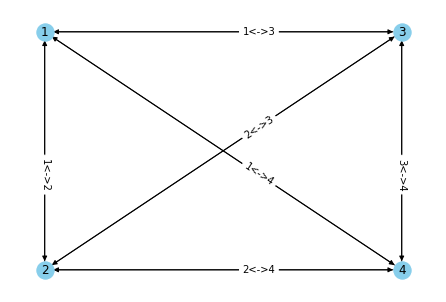

In [2]:
G = nx.DiGraph(directed=True)
G.add_node(1)
G.add_node(2)
G.add_node(3)
G.add_node(4)

G.add_edge(1, 2)
G.add_edge(1, 3)
G.add_edge(1, 4)

G.add_edge(2, 1)
G.add_edge(2, 3)
G.add_edge(2, 4)

G.add_edge(3, 1)
G.add_edge(3, 2)
G.add_edge(3, 4)

G.add_edge(4, 1)
G.add_edge(4, 2)
G.add_edge(4, 3)

pos = {1: [0, 1],
      2: [0, 0],
      3: [1, 1],
      4: [1, 0]}


edge_labels = {(1, 2): '1<->2',
              (1, 3): '1<->3',
              (1, 4): '1<->4',
              (2, 3): '2<->3',
              (2, 4): '2<->4',
              (3, 4): '3<->4',
              }

nx.draw(G, with_labels=True, node_color='skyblue', pos=pos)

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.4)
 
plt.show()

# Problem Instances Definition

In [3]:
dist_1_2 = 1
dist_1_3 = 8
dist_1_4 = 3
dist_2_3 = 3
dist_2_4 = 2
dist_3_4 = 1

distances_sum = sum([dist_1_2, dist_1_3, dist_1_4, dist_2_3, dist_2_4, dist_3_4])

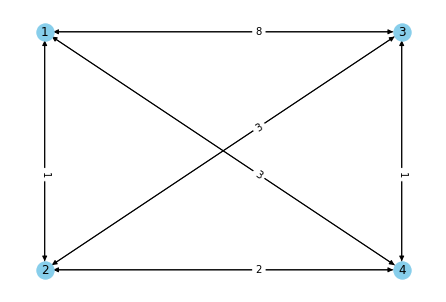

In [4]:
edge_labels = {(1, 2): dist_1_2,
              (1, 3): dist_1_3,
              (1, 4): dist_1_4,
              (2, 3): dist_2_3,
              (2, 4): dist_2_4,
              (3, 4): dist_3_4
              }

nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.4)
 
plt.show()

## Utility Functions

In [5]:
def controlled_unitary(qc, qubits: list, phases: list): # x,y,z = Specific Qubit; a,b,c,d = Phases
    qc.cp(phases[2]-phases[0], qubits[0], qubits[1]) # controlled-U1(c-a)
    qc.p(phases[0], qubits[0]) # U1(a)
    qc.cp(phases[1]-phases[0], qubits[0], qubits[2]) # controlled-U1(b-a)
    
    # controlled controlled U1(d-c+a-b)
    qc.cp((phases[3]-phases[2]+phases[0]-phases[1])/2, qubits[1], qubits[2])
    qc.cx(qubits[0], qubits[1])
    qc.cp(-(phases[3]-phases[2]+phases[0]-phases[1])/2, qubits[1], qubits[2])
    qc.cx(qubits[0], qubits[1])
    qc.cp((phases[3]-phases[2]+phases[0]-phases[1])/2, qubits[0], qubits[2])
    
def U(times, qc, unit, eigen, phases: list): # a,b,c = phases for U1; d,e,f = phases for U2; g,h,i = phases for U3; j,k,l = phases for U4; m_list=[m, n, o, p, q, r, s, t, u, a, b, c, d, e, f, g, h, i, j, k, l]
    controlled_unitary(qc, [unit[0]]+eigen[0:2], [0]+phases[0:3])
    controlled_unitary(qc, [unit[0]]+eigen[2:4], [phases[3]]+[0]+phases[4:6])
    controlled_unitary(qc, [unit[0]]+eigen[4:6], phases[6:8]+[0]+[phases[8]])
    controlled_unitary(qc, [unit[0]]+eigen[6:8], phases[9:12]+[0])
    
def final_U(times, eigen, phases: list):
    unit = QuantumRegister(1, 'unit')
    qc = QuantumCircuit(unit, eigen)
    for _ in range(2**times):
        U(times, qc, unit, eigen, phases)
    return qc.to_gate(label='U'+'_'+(str(2**times)))


# Function to place appropriate corresponding gate according to eigenstates
def eigenstates(qc, eigen, index):
    for i in range(0, len(eigen)):
        if eigen_values[index][i] == '1':
            qc.x(eigen[i])
        if eigen_values[index][i] == '0':
            pass
    qc.barrier()
    return qc

def int_to_phase(distance):
    phase = distance/distances_sum * 2 * np.pi
    return phase

def phase_to_int(phase):
    return phase/(2*np.pi) * distances_sum 

def eigenvalue_to_route(eigenvalue:str):
    a = (int(eigenvalue[0:2],2)+1)
    b = (int(eigenvalue[2:4],2)+1)
    c = (int(eigenvalue[4:6],2)+1)
    d = (int(eigenvalue[6:8],2)+1)
    return [a,b,c,d]

def extract_selected_graph(solution):
    
    G = nx.Graph()
    for i in range(len(solution)):
        if i == len(solution) - 1:
            G.add_edge(solution[i], solution[0], color='r',weight=2)
        else:
            G.add_edge(solution[i], solution[i+1], color='r',weight=2)
    
    return G

## Problem Encoding, Execution, and Decoding

In [6]:
# Assign phase to each edge
a = int_to_phase(dist_1_2)
d = a
b = int_to_phase(dist_1_3)
g = b
c = int_to_phase(dist_1_4)
j = c
e = int_to_phase(dist_2_3)
h = e
f = int_to_phase(dist_2_4)
k = f
i = int_to_phase(dist_3_4)
l = i

# Storing the eigenvalues in a list
eigen_values = ["11000110", "10001101", "10000111"]

all_perms=[]
all_costs=[]
for index_eigenstate in (0,1,2):
    num_qubits_qft = 4
    # Initialization
    unit = QuantumRegister(num_qubits_qft, 'unit')
    eigen = QuantumRegister(8, 'eigen')
    unit_classical = ClassicalRegister(num_qubits_qft, 'unit_classical')
    qc = QuantumCircuit(unit, eigen, unit_classical)

    eigenstates(qc, eigen, index_eigenstate)

    qc.h(unit[:])
    qc.barrier()

    # Controlled Unitary  
    phases = [a, b, c, d, e, f, g, h, i, j, k, l]
    for i in range(0, num_qubits_qft):
        qc.append(final_U(i, eigen, phases), [unit[num_qubits_qft-1-i]] + eigen[:])
    

    # Inverse QFT 
    qc.barrier()
    qft = QFT(num_qubits=len(unit), inverse=True, insert_barriers=True, do_swaps=False, name='Inverse QFT')
    qc.append(qft, qc.qubits[:len(unit)])
    qc.barrier()
    

    # Measure
    qc.measure(unit, unit_classical)

    # Simulate and calculate phase
    backend = Aer.get_backend('qasm_simulator')
    job = execute(qc, backend, shots=10000)
    count = job.result().get_counts()
    #print(count)
    #plot_histogram(count)
    most_frequent_decimal = int(count.most_frequent(),2)
    phase = most_frequent_decimal/(2**num_qubits_qft)
    route = eigenvalue_to_route(eigen_values[index_eigenstate])
    costs = phase_to_int(phase)
    print("Eigenstate: ", eigen_values[index_eigenstate])
    print("Route: ", route)
    print("Phase: ", phase)
    print("Costs: ", costs)
    all_perms.append(route)
    all_costs.append(costs)
#qc.draw(output='mpl', fold=-1)
sol_perm = all_perms[np.argmin(all_costs)]
print("### Solution: ", sol_perm)

/Users/nils/miniforge3/envs/tf3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/nils/miniforge3/envs/tf3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Eigenstate:  11000110
Route:  [4, 1, 2, 3]
Phase:  0.4375
Costs:  1.2533451768486759
Eigenstate:  10001101
Route:  [3, 1, 4, 2]
Phase:  0.0625
Costs:  0.17904931097838225
Eigenstate:  10000111
Route:  [3, 1, 2, 4]
Phase:  0.6875
Costs:  1.9695424207622048
### Solution:  [3, 1, 4, 2]


## Visualizat and Compare Solutions

### Quantum Solution

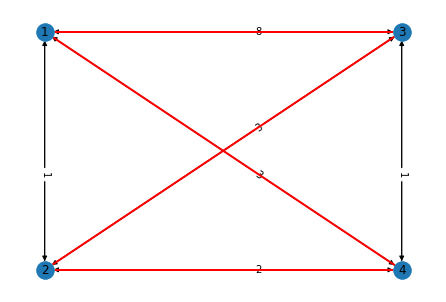

In [7]:
edge_labels = {(1, 2): dist_1_2,
              (1, 3): dist_1_3,
              (1, 4): dist_1_4,
              (2, 3): dist_2_3,
              (2, 4): dist_2_4,
              (3, 4): dist_3_4
              }
selected_graph = extract_selected_graph(sol_perm)

edges = selected_graph.edges()
colors = [selected_graph[u][v]['color'] for u,v in edges]
weights = [selected_graph[u][v]['weight'] for u,v in edges]


nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.4)
nx.draw(selected_graph, pos, edge_color=colors, width=weights)
 
plt.show()

### Classical Solution

[1 2 3 4] 8


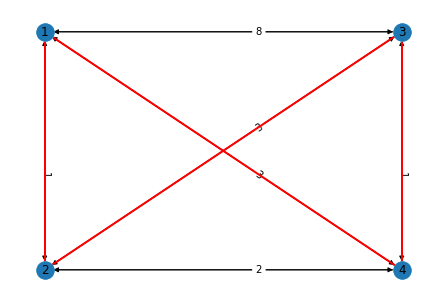

In [8]:
distance_matrix = np.array([
    [0,  dist_1_2, dist_1_3, dist_1_4],
    [dist_1_2,  0, dist_2_3,  dist_2_4],
    [dist_1_3,  dist_2_3, 0,  dist_3_4],
    [dist_1_4, dist_2_4, dist_3_4,  0]
])
permutation, distance = solve_tsp_dynamic_programming(distance_matrix)
print(np.array(permutation)+1, distance)

edge_labels = {(1, 2): dist_1_2,
              (1, 3): dist_1_3,
              (1, 4): dist_1_4,
              (2, 3): dist_2_3,
              (2, 4): dist_2_4,
              (3, 4): dist_3_4
              }
selected_graph = extract_selected_graph(np.array(permutation)+1)

edges = selected_graph.edges()
colors = [selected_graph[u][v]['color'] for u,v in edges]
weights = [selected_graph[u][v]['weight'] for u,v in edges]


nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.4)
nx.draw(selected_graph, pos, edge_color=colors, width=weights)
 
plt.show()